In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import os

### Labels

In [40]:
train_path = 'datasets/Intel Image Classification/seg_train/seg_train/'
_, labels, _ = next(os.walk(train_path))
print("Labels :",labels)

Labels : ['sea', 'mountain', 'street', 'buildings', 'glacier', 'forest']


### Encode-Decode Labels

In [41]:
encode = dict()
decode = dict()
for x in enumerate(labels):
    encode[x[1]]=x[0]
    decode[x[0]]=x[1]
print('Labels Encoder :', encode)
print('Labels Decoder :', decode)

Labels Encoder : {'sea': 0, 'mountain': 1, 'street': 2, 'buildings': 3, 'glacier': 4, 'forest': 5}
Labels Decoder : {0: 'sea', 1: 'mountain', 2: 'street', 3: 'buildings', 4: 'glacier', 5: 'forest'}


### Define Train arrays: x_train, y_train

In [32]:
train_path = 'datasets/Intel Image Classification/seg_train/seg_train/'

x_train = list()
y_train = list()

for x in labels:
    for i in os.listdir(train_path+x):
        im = Image.open(train_path+x+'/'+i)
        im = im.resize((60,60), Image.ANTIALIAS) # Resize Image
        im = np.array(im) # Convert Image to Numpy Array
        im = im/255.0 # Normalise Images
        x_train.append(im)
        y_train.append(encode[x]) # Append Encoded Labels

# Convert Train Dataset Lists to Numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Save Train Arrays
np.save('datasets/Intel Image Classification/x_train.npy',x_train)
np.save('datasets/Intel Image Classification/y_train.npy',y_train)

### Define Test arrays: x_test, y_test

In [33]:
test_path = 'datasets/Intel Image Classification/seg_test/seg_test/'

x_test = list()
y_test = list()

for x in labels:
    for i in os.listdir(test_path+x):
        im = Image.open(test_path+x+'/'+i)
        im = im.resize((60,60), Image.ANTIALIAS) # Resize Image
        im = np.array(im) # Convert Image to Numpy Array
        im = im/255.0 # Normalise Images
        x_test.append(im)
        y_test.append(encode[x]) # Append Encoded Labels

# Convert Test Dataset Lists to Numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Save Test Arrays
np.save('datasets/Intel Image Classification/x_test.npy',x_test)
np.save('datasets/Intel Image Classification/y_test.npy',y_test)

### Load Train & Test Arrays

In [42]:
x_train = np.load('datasets/Intel Image Classification/x_train.npy')
y_train = np.load('datasets/Intel Image Classification/y_train.npy')
x_test = np.load('datasets/Intel Image Classification/x_test.npy')
y_test = np.load('datasets/Intel Image Classification/y_test.npy')

### Model

In [43]:
model = Sequential()
model.add(Conv2D(68, kernel_size=(3,3),padding='same', input_shape=(60,60,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(46, kernel_size=(3,3), padding='same'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(34, kernel_size=(3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(26, kernel_size=(3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(38, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

# We will use 'sparse_categorical_crossentropy' as our loss function,
# as we defined our classifier as a probability distribution of classes

# Low Learning rate gives us a more accurate model, but takes more time to train
model.compile(optimizer=Adam(lr=0.000125),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 60, 60, 68)        1904      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 68)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 46)        28198     
_________________________________________________________________
dropout_23 (Dropout)         (None, 30, 30, 46)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 15, 46)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 15, 46)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 34)       

### Train Model

In [45]:
# Train for 50 epochs to get the best out of the model
# Or navigate to the next cell to load Pre-trained model
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=10)
model.save('Landscape-Classifier.h5')

# Plot Accuracy against Epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Number of epochs')
plt.legend(loc='lower right')
plt.show()

### Load Pre-Trained Model

In [46]:
# Load Pre-Trained Weights & Biases
model = keras.models.load_model('Landscape-Classifier.h5')

_, train_acc = model.evaluate(x_train, y_train)
_, test_acc = model.evaluate(x_test, y_test)

print('Train Accuracy :', train_acc)
print('Test Accuracy :', test_acc)

94/94 [==============================] - 1s 11ms/step - loss: 0.5887 - accuracy: 0.8060
Train Accuracy : 0.839888870716095
Test Accuracy : 0.8059999942779541


### Predict

In [51]:
pred_path = 'datasets/Intel Image Classification/seg_pred/seg_pred/'
files = list() # This will contain all the image names in directory pred_path
images = list() # This will contain all the images to predict

for x in os.listdir(pred_path):
    files.append(x)

for N in range(len(files)):
    im = Image.open(pred_path+files[N]) # Open Image of index N in 'files'
    im = im.resize((60,60), Image.ANTIALIAS) # Resize Image
    im = np.array(im)
    im = im/255.0 # Normalise pixel values
    images.append(im)

images = np.array(images)
prediction = model.predict(images)

Predicted : buildings


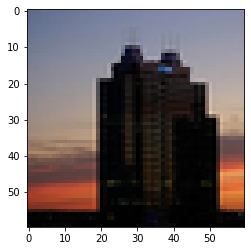

In [59]:
# Display Prediction

N = 10 # Index of Image to display
plt.imshow(images[N])

# Prediction is a probability distribution between classes
# So the index with the highest probability is the Predicted class
# Use np.argmax to get that index with highest probability
# then pass it to 'decode' dict we defined before
# And we get our Prediction
print("Predicted :", decode[np.argmax(prediction[N])]) 
plt.show()